# DeepSurv-Breast-Prognosis
**Team:** ByteRunners

**Competition:** BioFusion Hackathon 2026

**Problem:** Predicting 5-Year Survival Risk in Breast Cancer Patients.

**Dataset:** METABRIC (Nature 2012), obtained from cBioPortal.

### 1: Preparing the environment

In [1]:
!pip install scikit-survival pandas matplotlib seaborn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.1/846.1 kB 1.0 MB/s eta 0:00:00a 0:00:01
  Created wheel for ecos: filename=ecos-2.0.14-cp313-cp313-macosx_11_0_arm64.whl size=75422 sha256=ae76e7f775d0cf19bbb2e8fdfd72811eefe0aee95535a1138daa9a3e993f1877
  Stored in directory: /Users/pasan/Library/Caches/pip/wheels/6b/82/0b/4bb5aa6c4618f367601a45db8710205d56858808423974e92a
Successfully built ecos
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-survival]


### 2: DATA LOADING & SURVIVAL PREPROCESSING

In [2]:
# ---------------------------------------------------------
# CELL 2: DATA LOADING & SURVIVAL PREPROCESSING
# ---------------------------------------------------------

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sksurv.util import Surv

# 1. Load Data
df = pd.read_csv('brca_metabric_clinical_data.tsv', sep='\t')

# 2. Select High-Value Features
# We include 'time' and 'status' for the target, and others for training
cols_to_keep = [
    'Age at Diagnosis', 'Chemotherapy', 'Radiotherapy',
    'Tumor Size', 'Tumor Stage', 'Neoplasm Histologic Grade',
    'Lymph Nodes Examined Positive', 'Mutation Count', 'Nottingham Prognostic Index',
    'Overall Survival (Months)', 'Overall Survival Status' # TARGETS
]

# Filter columns that actually exist in your dataframe
existing_cols = [c for c in cols_to_keep if c in df.columns]
data = df[existing_cols].copy()

# 3. Clean Target Variables
# Drop rows with missing Time or Status
data = data.dropna(subset=['Overall Survival (Months)', 'Overall Survival Status'])

# Convert Status to Boolean (True = Event/Death occurred, False = Censored/Living)
# Adjust the string 'DECEASED' if your file uses '1:DECEASED' or similar
data['Event'] = data['Overall Survival Status'].astype(str).apply(lambda x: True if 'DECEASED' in x.upper() else False)
data['Time'] = data['Overall Survival (Months)']

# 4. Handle Missing Values in Features
# Drop the original target columns from X
X = data.drop(['Overall Survival (Months)', 'Overall Survival Status', 'Event', 'Time'], axis=1)

# Impute numbers with Median
num_cols = X.select_dtypes(include=np.number).columns
if len(num_cols) > 0:
    imp_num = SimpleImputer(strategy='median')
    X[num_cols] = imp_num.fit_transform(X[num_cols])

# One-Hot Encode Categorical Data (Required for RSF)
X = pd.get_dummies(X, drop_first=True)

# 5. Create Structured Target Array
# This is the "Complex" part: sksurv needs a structured numpy array
y = Surv.from_arrays(event=data['Event'].values, time=data['Time'].values)

print(f"Processed Data: {X.shape[0]} samples, {X.shape[1]} features.")
print("Target format example:", y[:5]) # Should look like [(False, 120.5), (True, 45.2)...]

Processed Data: 1981 samples, 6 features.
Target format example: [(False, 140.5       ) (False,  84.63333333) ( True, 163.7       )
 (False, 164.93333333) ( True,  41.36666667)]


### 3: RANDOM SURVIVAL FOREST TRAINING

In [3]:
# ---------------------------------------------------------
# CELL 3: RANDOM SURVIVAL FOREST TRAINING
# ---------------------------------------------------------
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored

# 1. Split Data
# Note: stratify=y doesn't work easily with structured arrays, so we use random split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Initialize the Complex Model
# n_estimators=1000 makes it robust. min_samples_leaf=15 prevents overfitting.
rsf = RandomSurvivalForest(
    n_estimators=1000,
    min_samples_split=10,
    min_samples_leaf=15,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)

print("Training Random Survival Forest... (this might take a minute)")
rsf.fit(X_train, y_train)

# 3. Evaluate with C-Index (The Gold Standard Metric)
# C-Index > 0.7 is usually considered strong in medical data
score = rsf.score(X_test, y_test)
print(f"\n✅ Model C-Index (Accuracy equivalent): {score:.4f}")

# Compare to dummy baseline (0.5 is random guessing)
print(f"Improvement over random guessing: {((score - 0.5) / 0.5) * 100:.1f}%")

Training Random Survival Forest... (this might take a minute)

✅ Model C-Index (Accuracy equivalent): 0.6641
Improvement over random guessing: 32.8%


### 4: SURVIVAL CURVES & PERMUTATION IMPORTANCE

/var/folders/f8/s7_j6j8j5y5dccj4rpr3xjgw0000gn/T/ipykernel_32500/1160335064.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


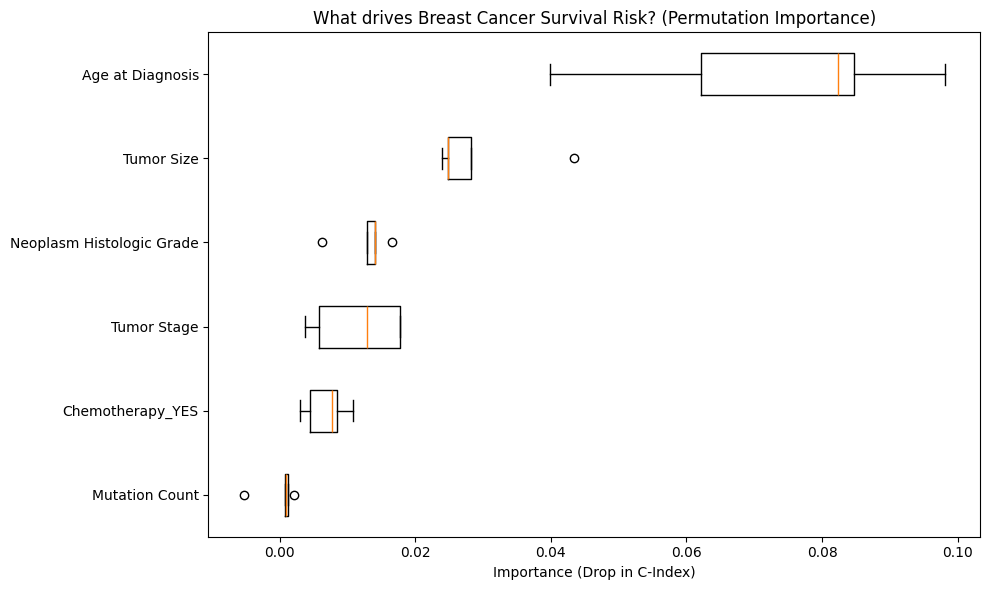

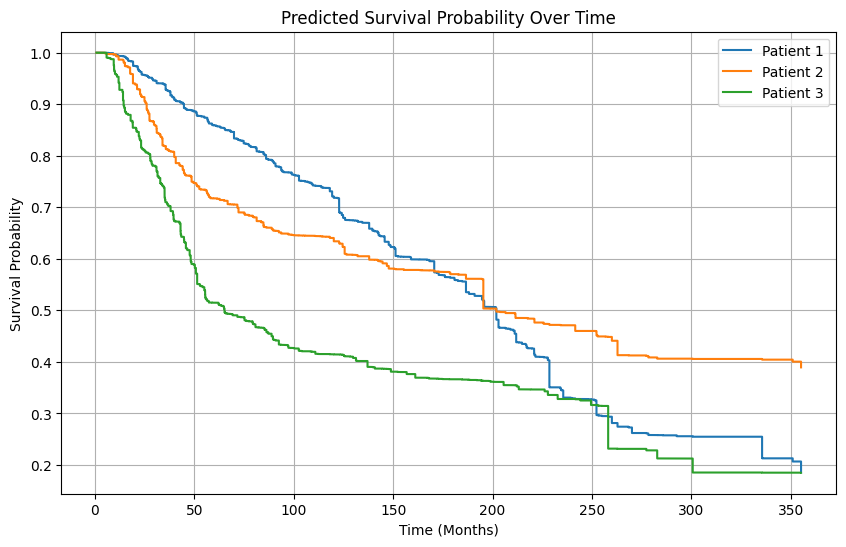

In [4]:
# ---------------------------------------------------------
# CELL 4: SURVIVAL CURVES & PERMUTATION IMPORTANCE
# ---------------------------------------------------------
import matplotlib.pyplot as plt

# 1. Feature Importance (Why does the model predict risk?)
# In RSF, we use permutation importance (more accurate than standard importance)
from sklearn.inspection import permutation_importance

result = permutation_importance(rsf, X_test, y_test, n_repeats=5, random_state=42)

# Plot Top 10 Features
sorted_idx = result.importances_mean.argsort()[-10:]

plt.figure(figsize=(10, 6))
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=X_test.columns[sorted_idx]
)
plt.title("What drives Breast Cancer Survival Risk? (Permutation Importance)")
plt.xlabel("Importance (Drop in C-Index)")
plt.tight_layout()
plt.show()

# 2. Patient Survival Curves (The "Clinical Utility" Chart)
# Let's predict survival curves for the first 3 patients in the test set
surv_funcs = rsf.predict_survival_function(X_test[:3])

plt.figure(figsize=(10, 6))
for i, fn in enumerate(surv_funcs):
    plt.step(fn.x, fn(fn.x), where="post", label=f"Patient {i+1}")

plt.title("Predicted Survival Probability Over Time")
plt.ylabel("Survival Probability")
plt.xlabel("Time (Months)")
plt.legend()
plt.grid(True)
plt.show()